# Down the rabbit hole with Tensorflow

![img](https://lh3.googleusercontent.com/I1Dpp7I9RZIGl0rVMlPfnhfl-bkl_2uDHZwVC87BWmqtPaAs1irMWOdJxTmTEQJB-VGfLryCyHxqvyNchVIVLL-vqGrF3Q=s688)

In this seminar, we're going to play with [Tensorflow](https://www.tensorflow.org/) and see how it helps you build deep learning models.

If you're running this notebook outside the course environment, you'll need to install tensorflow:
* `pip install tensorflow` should install cpu-only TF on Linux & Mac OS
* If you want GPU support from offset, see [TF install page](https://www.tensorflow.org/install/)

In [0]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week1_intro/primer/mnist.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Selecting previously unselected package xvfb.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow as tf

# session is main tensorflow object. You ask session to compute stuff for you.
sess = tf.InteractiveSession()

# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [0]:
def sum_squares1(N):
    S = 0
    for x in range(1,N+1):
        S = S + x*x
    return S
    
def sum_squares(N):
    n = np.arange(N+1)
    return np.sum(n*n)

In [0]:
# numpy has pecision limits
n = np.arange(100000)
print (np.sum(n))
print (type(np.sum(n)))

# python default operation is without precision limitation
n = 2**63
print(n,n*n,n*n*n)

4999950000
<class 'numpy.int64'>
9223372036854775808 85070591730234615865843651857942052864 784637716923335095479473677900958302012794430558004314112


In [0]:
%%time
#s1=sum_squares1(10**8)
#print(s1)
s2=sum_squares (10**8)
print(s2)


672921401752298880
CPU times: user 338 ms, sys: 705 ms, total: 1.04 s
Wall time: 1.05 s


__Same with tensorflow__

In [0]:
# "i will insert N here later"
N = tf.placeholder('int64', name="input_to_your_function")

# a recipe on how to produce {sum of squares of arange of N} given N
result = tf.reduce_sum((tf.range(N)**2))

In [0]:
%%time

# dear session, compute the result please. Here's your N.
print(sess.run(result, {N: 10**8}))

# hint: run it several times to let tensorflow "warm up"

662921401752298880
CPU times: user 546 ms, sys: 1.08 ms, total: 547 ms
Wall time: 433 ms


# How it works: computation graphs


1. create placeholders for future inputs;
2. define symbolic graph: a recipe for mathematical transformation of those placeholders;
3. compute outputs of your graph with particular values for each placeholder
  * ```sess.run(outputs, {placeholder1:value1, placeholder2:value2})```
  * OR output.eval({placeholder:value}) 

Still confused? We gonna fix that.

__Placeholders and constants__

In [0]:
# placeholder that can be arbitrary float32 scalar, vertor, matrix, etc.
arbitrary_input = tf.placeholder('float32')

# input vector of arbitrary length
input_vector = tf.placeholder('float32', shape=(None,))

# input vector that _must_ have 10 elements and integer type
fixed_vector = tf.placeholder('int32', shape=(10,))

# you can generally use None whenever you don't need a specific shape
input1 = tf.placeholder('float64', shape=(None, 100, None))
input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

You can create new __tensors__ with arbitrary operations on placeholders, constants and other tensors.

* tf.reduce_sum(tf.arange(N)\**2) are 3 sequential transformations of placeholder N
* there's a tensorflow symbolic version for every numpy function
  * `a + b, a / b, a ** b, ...` behave just like in numpy
  * np.zeros -> tf.zeros
  * np.sin -> tf.sin
  * np.mean -> tf.reduce_mean
  * np.arange -> tf.range
  
There are tons of other stuff in tensorflow, see the [docs](https://www.tensorflow.org/api_docs/python) or learn as you go with __shift+tab__.

In [0]:
# elementwise multiplication
double_the_vector = input_vector * 2

# elementwise cosine
elementwise_cosine = tf.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector

# elementwise difference between squared vector and it's means - with some random salt
vector_squares = input_vector ** 2 - \
    tf.reduce_mean(input_vector) + tf.random_normal(tf.shape(input_vector))




In [0]:
#Practice time: create two vectors of type float32
my_vector  = tf.placeholder('float32')
my_vector2 = tf.placeholder('float32')

#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = (my_vector*my_vector2)/(tf.sin(my_vector)+1)

print(my_transformation)
#it's okay, it's a symbolic graph

dummy = np.arange(5).astype('float32')
my_transformation.eval( { my_vector:dummy, my_vector2:dummy[::-1] } )


Tensor("truediv_4:0", dtype=float32)


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

## Practice 1: polar pretzels
_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

There are some simple mathematical functions with cool plots. For one, consider this:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$


In [0]:
np.linspace(-10, 10, num=13)

array([-10.        ,  -8.33333333,  -6.66666667,  -5.        ,
        -3.33333333,  -1.66666667,   0.        ,   1.66666667,
         3.33333333,   5.        ,   6.66666667,   8.33333333,
        10.        ])

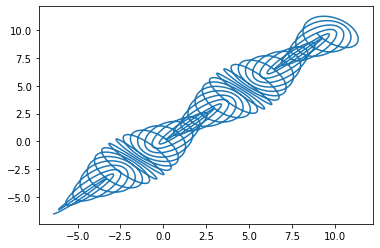

In [0]:
t = tf.placeholder('float32')

# compute x(t) and y(t) as defined above.
x = t - 1.5*tf.cos(15*t)
y = t - 1.5*tf.sin(16*t)

x_points, y_points = sess.run([x, y], {t: np.linspace(-5, 10, num=10000)})
plt.plot(x_points, y_points)

### Visualizing graphs with Tensorboard

It's often useful to visualize the computation graph when debugging or optimizing. 
Interactive visualization is where tensorflow really shines as compared to other frameworks. 

There's a special instrument for that, called Tensorboard. You can launch it from console:

__```tensorboard --logdir=/tmp/tboard --port=7007```__

If you're pathologically afraid of consoles, try this:

__```import os; os.system("tensorboard --logdir=/tmp/tboard --port=7007 &")```__

_(but don't tell anyone we taught you that)_

In [0]:
#tensorboard --logdir=/tmp/tboard --port=7007
#import os; 
#os.system("tensorboard --logdir=/tmp/tboard --port=7007 &")

# launch tensorflow the ugly way, uncomment if you need that
import os
port = 6000 + os.getuid()
print("Port: %d" % port)
#!killall tensorboard
os.system("tensorboard --logdir=./tboard --port=%d &" % port)
# show graph to tensorboard
writer = tf.summary.FileWriter("./tboard", graph=tf.get_default_graph())
writer.close()


Port: 6000


One basic functionality of tensorboard is drawing graphs. One you've run the cell above, go to `localhost:7007` in your browser and switch to _graphs_ tab in the topbar. 

Here's what you should see:

<img src="https://www.tensorflow.org/images/graph_vis_animation.gif" width=480>

Tensorboard also allows you to draw graphs (e.g. learning curves), record images & audio ~~and play flash games~~. This is useful when monitoring learning progress and catching some training issues.

One researcher said:
```
If you spent last four hours of your worktime watching as your algorithm prints numbers and draws figures, you're probably doing deep learning wrong.
```

You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz)

# Practice 2: mean squared error


In [0]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

#<student.define_inputs_and_transformations()>
#mse = <student.define_transformation()>
#compute_mse = lambda vector1, vector2: sess.run( < how to run you graph?> , {})

vector1 = tf.placeholder('float32',shape=(None,))
vector2 = tf.placeholder('float32',shape=(None,))
mse = tf.reduce_mean((vector1-vector2)**2)
#compute_mse = lambda v1, v2: mse.eval({vector1:v1,vector2:v2})
compute_mse = lambda v1, v2: sess.run( mse, {vector1:v1,vector2:v2} )


In [0]:
v1 = np.arange(3).astype('float32')
v2 = np.arange(3,6,1).astype('float32')
print(v1)
print(v2)
print(" --> " , (v1-v2)**2)
print(" --> " , np.mean((v1-v2)**2))
#r = sess.run(mse, {vector1:v1,vector2:v2} )
#r = mse.eval( {vector1:v1,vector2:v2} )
r = compute_mse( v1,v2 )
print(r)


[0. 1. 2.]
[3. 4. 5.]
 -->  [9. 9. 9.]
 -->  9.0
9.0


In [0]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10 ** 3]:

    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]

    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            print("true_mse=",true_mse," my_mse=",my_mse)
            if not np.allclose(true_mse, my_mse):
                print('Wrong result:')
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" %
                      (true_mse, my_mse))
                raise ValueError("Что-то не так")

print("All tests passed")

true_mse= 0.0  my_mse= 0.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.0  my_mse= 0.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.1838338422559011  my_mse= 0.18383385
true_mse= 5776.0  my_mse= 5776.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.0  my_mse= 0.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.0  my_mse= 0.0
true_mse= 0.3263168634014854  my_mse= 0.32631686
true_mse= 5625.0  my_mse= 5625.0
true_mse= 0.0  my_mse= 0.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.0  my_mse= 0.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.1838338422559011  my_mse= 0.18383385
true_mse= 5776.0  my_mse= 5776.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.0  my_mse= 0.0
true_mse= 1.0  my_mse= 1.0
true_mse= 0.0  my_mse= 0.0
true_mse= 0.3263168634014854  my_mse= 0.32631686
true_mse= 5625.0  my_mse= 5625.0
true_mse= 0.1838338422559011  my_mse= 0.18383385
true_mse= 0.3263168634014854  my_mse= 0.32631686
true_mse= 0.1838338422559011  my_mse= 0.18383385
true_mse= 0.3263168634014854  my_mse= 0.32631686
true_mse= 0.0  my_mse= 0.0
true_mse= 5711.01

# Tensorflow variables

The inputs and transformations have no value outside function call. That's a bit unnatural if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [0]:
# creating shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5))

# initialize all variables with initial values
sess.run(tf.global_variables_initializer())

In [0]:
# evaluating shared variable (outside symbolicd graph)
print("initial value", sess.run(shared_vector_1))

# within symbolic graph you use them just as any other inout or transformation, not "get value" needed

initial value [1. 1. 1. 1. 1.]


In [0]:
# setting new value manually
sess.run(shared_vector_1.assign(np.arange(5)))

# getting that new value
print("new value", sess.run(shared_vector_1))

new value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* Gradients are computed as a product of elementary derivatives via chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [0]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar ** 2

# a derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar])[0]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


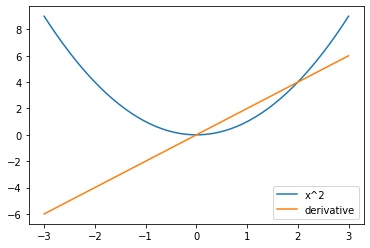

In [0]:
x = np.linspace(-3, 3)
x_squared, x_squared_der = sess.run(
    [scalar_squared, derivative], {my_scalar: x})

plt.plot(x, x_squared, label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

## Why autograd is cool

In [0]:
my_vector = tf.placeholder('float32', [None])

# Compute the gradient of the next weird function over my_scalar and my_vector
# warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = tf.reduce_mean((my_vector+my_scalar)**(1+tf.nn.moments(my_vector, [0])[1]) + 1. / tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector) * my_scalar**2)*tf.exp((my_scalar-4)**2)/(1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2))/(1+tf.exp(-(my_scalar-4)**2)))**2


der_by_scalar = tf.gradients(weird_psychotic_function,my_scalar)[0]
der_by_vector = tf.gradients(weird_psychotic_function,my_vector)[0]



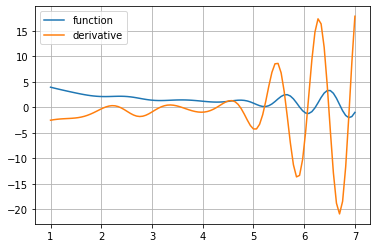

In [0]:
# Plotting your derivative
scalar_space = np.linspace(1, 7, 100)

y = [sess.run(weird_psychotic_function, {my_scalar: x, my_vector: [1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [sess.run(der_by_scalar, {my_scalar: x, my_vector: [1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend()

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [0]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2)

optimizer = tf.train.MomentumOptimizer(
    0.01, 0.9).minimize(loss, var_list=y_guess)

# same, but more detailed:
# updates = [[tf.gradients(loss,y_guess)[0], y_guess]]
# optimizer = tf.train.MomentumOptimizer(0.01,0.9).apply_gradients(updates)

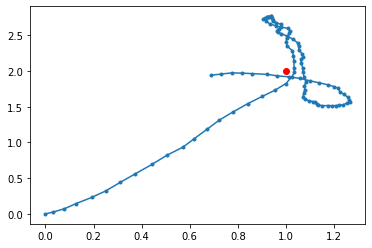

In [0]:
from IPython.display import clear_output

sess.run(tf.global_variables_initializer())

guesses = [sess.run(y_guess)]

for _ in range(100):
    sess.run(optimizer)
    guesses.append(sess.run(y_guess))

    clear_output(True)
    plt.plot(*zip(*guesses), marker='.')
    plt.scatter(*sess.run(y_true), c='red')
    plt.show()

# Logistic regression example
Implement the regular logistic regression training algorithm
 
We shall train on a two-class MNIST dataset. 

This is a binary classification problem, so we'll train a __Logistic Regression with sigmoid__.
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


The natural choice of loss function is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$

Mind the minus :)


In [0]:
from sklearn.datasets import load_digits
X, y = load_digits(2, return_X_y=True)

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:


X:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.]
 [ 0.  0.  1.  9. 15. 11.  0.  0.  0.  0.]]
y:
 [0 1 0 1 0 1 0 0 1 1]


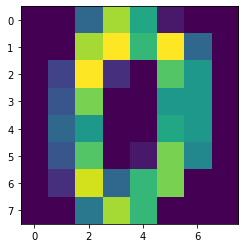

In [0]:
print('X:\n', X[:3, :10])
print('y:\n', y[:10])
plt.imshow(X[0].reshape([8, 8]))

In [0]:
# inputs and shareds
#weights = <student.create_variable()>
#input_X = <student.create_placeholder_matrix()>
#input_y = <student.code_placeholder_vector()>

weights = tf.Variable(initial_value=tf.random_normal([64]))
input_X = tf.placeholder('float32',shape=[None,64])
input_y = tf.placeholder('float32',shape=[None])

In [0]:
#predicted_y_proba = <predicted probabilities for input_X using weights>

#loss = <logistic loss(scalar, mean over sample) between predicted_y_proba and input_y>

#train_step = <operator that minimizes loss>

predicted_y = 1/(1+tf.exp(tf.reduce_sum((-weights*input_X),axis=1)))
loss = tf.losses.log_loss(input_y,predicted_y)
optimizer = tf.train.MomentumOptimizer(0.01,0.9).minimize(loss)


In [0]:
train_function = lambda XX,yy: sess.run([loss,weights,optimizer],feed_dict={input_X:XX,input_y:yy})
predict_function = lambda XX:predicted_y.eval(feed_dict={input_X:XX})

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from sklearn.metrics import roc_auc_score

sess.run(tf.global_variables_initializer())

for i in range(5):

    #loss_i, _ = sess.run([loss, train_step],  # <YOUR CODE: feed values to placeholders>)
    #print("loss at iter %i: %.4f" % (i, loss_i))
    #print("train auc:", roc_auc_score(y_train, sess.run(predicted_y_proba, {input_X: X_train})))
    #print("test auc:", roc_auc_score(y_test, sess.run(predicted_y_proba, {input_X: X_test})))

    r = train_function(X_train,y_train)
    loss_i = r[0]
    print("loss at iter %i:%.4f" % (i,loss_i))
    print("train auc:",roc_auc_score(y_train, predict_function(X_train)))
    print(" test auc:",roc_auc_score(y_test, predict_function(X_test)))


print("resulting weights:")
#plt.imshow(shared_weights.get_value().reshape(8, -1))
#plt.colorbar();


loss at iter 0:9.8735
train auc: 0.13252086078173034
 test auc: 0.08695652173913043
loss at iter 1:9.5836
train auc: 0.153903162055336
 test auc: 0.10869565217391303
loss at iter 2:9.1043
train auc: 0.18681379007465965
 test auc: 0.14624505928853754
loss at iter 3:8.5750
train auc: 0.22831576635924464
 test auc: 0.1892292490118577
loss at iter 4:8.1672
train auc: 0.277475845410628
 test auc: 0.23567193675889328
resulting weights:


# Practice 3: my first tensorflow network
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure tensorflow.

This time you will same digit recognition problem, but at a larger scale
* images are now 28x28
* 10 different digits
* 50k samples

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) NN should already have ive you an edge over logistic regression.

__[bonus score]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! The milestones would be 95%/97.5%/98.5% accuraсy on test set.

__SPOILER!__
At the end of the notebook you will find a few tips and frequently made mistakes. If you feel enough might to shoot yourself in the foot without external assistance, we encourage you to do so, but if you encounter any unsurpassable issues, please do look there before mailing us.

In [0]:
from mnist import load_dataset

# [down]loading the original MNIST dataset.
# Please note that you should only train your NN on _train sample,
#  _val can be used to evaluate out-of-sample error, compare models or perform early-stopping
#  _test should be hidden under a rock untill final evaluation... But we both know it is near impossible to catch you evaluating on it.
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print(X_train.shape, y_train.shape)

(50000, 1, 28, 28) (50000,)


(50000, 1, 28, 28)
(50000,)
(10000, 1, 28, 28)
(10000,)
(10000, 1, 28, 28)
(10000,)


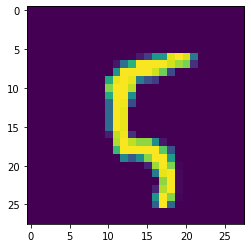

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

plt.imshow(X_train[100, 0])


In [0]:
print(X_train.shape)
xx = tf.reshape(X_train,[50000,784])
print(xx.shape)


(50000, 1, 28, 28)
(50000, 784)


In [0]:
X1 = [
     [ [ 2, 3, 4],
       [ 3, 4, 5 ] ],
     [ [ 12, 13, 14],
       [ 13, 14, 15 ] ],
     [ [ 22, 23, 24],
       [ 23, 24, 25 ] ]      
]
XX1 = np.array(X1)
print("old shape ", XX1.shape)
print(XX1)
xx = np.reshape(X1,[3,6])
print("new shape ", xx.shape)
xx


old shape  (3, 2, 3)
[[[ 2  3  4]
  [ 3  4  5]]

 [[12 13 14]
  [13 14 15]]

 [[22 23 24]
  [23 24 25]]]
new shape  (3, 6)


array([[ 2,  3,  4,  3,  4,  5],
       [12, 13, 14, 13, 14, 15],
       [22, 23, 24, 23, 24, 25]])

In [0]:
# Parameters
learning_rate = 0.1
num_steps = 100 # 500
batch_size = 128
display_step = 2  #100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = neural_net(X)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op  = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy     = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()





(50000, 784)
(50000,)
[5 0 4 1 9 2 1 3 1 4]
50000
1 : 5 : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
2 : 0 : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 : 4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
4 : 1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
5 : 9 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
6 : 2 : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7 : 1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
8 : 3 : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
9 : 1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
10 : 4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(50000, 10)


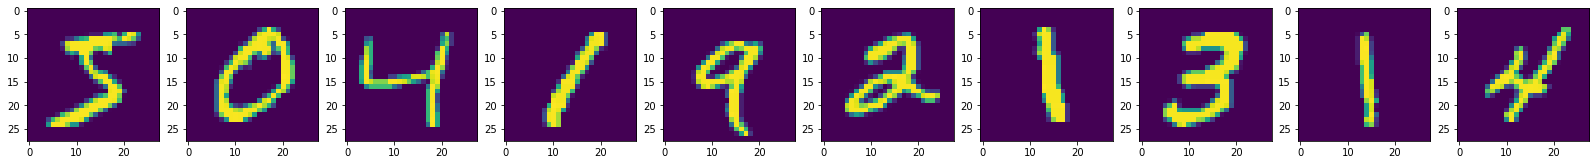

In [0]:
XX_train = np.reshape(X_train,[50000,784])
print(XX_train.shape)

print(y_train.shape)
print(y_train[0:10])
plt.figure(figsize=(28,28))
for i in range(10):    # from 0 to 9
  plt.subplot(1,10,i+1)
  plt.imshow(X_train[i, 0])
print(len(y_train))

yy_train = np.zeros(shape=(50000,10))
for i in range(50000):
  yy_train[i,y_train[i]]=1

for i in range(10):
  print(i+1,":",y_train[i],":", yy_train[i])
print(yy_train.shape)

In [0]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        #batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        #sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        sess.run(train_op, feed_dict={X: XX_train, Y: yy_train})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            #loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: XX_train, Y: yy_train})
            print("Step " + str(step) + ", Minibatch Loss= " + 
                  "{:.4f}".format(loss) + ", Training Accuracy= " + 
                  "{:.3f}".format(acc))

    print("Optimization Finished!")






Step 1, Minibatch Loss= 13251.4033, Training Accuracy= 0.293
Step 2, Minibatch Loss= 10921.7793, Training Accuracy= 0.393
Step 4, Minibatch Loss= 13585.2646, Training Accuracy= 0.463
Step 6, Minibatch Loss= 4251.8418, Training Accuracy= 0.669
Step 8, Minibatch Loss= 3830.3999, Training Accuracy= 0.641
Step 10, Minibatch Loss= 2026.6512, Training Accuracy= 0.754
Step 12, Minibatch Loss= 2525.2449, Training Accuracy= 0.742
Step 14, Minibatch Loss= 1973.1725, Training Accuracy= 0.762
Step 16, Minibatch Loss= 1288.8828, Training Accuracy= 0.845
Step 18, Minibatch Loss= 1171.0264, Training Accuracy= 0.846
Step 20, Minibatch Loss= 1410.7888, Training Accuracy= 0.827
Step 22, Minibatch Loss= 1340.0992, Training Accuracy= 0.837
Step 24, Minibatch Loss= 1186.1399, Training Accuracy= 0.851
Step 26, Minibatch Loss= 937.3789, Training Accuracy= 0.873
Step 28, Minibatch Loss= 831.3557, Training Accuracy= 0.881
Step 30, Minibatch Loss= 780.2868, Training Accuracy= 0.882
Step 32, Minibatch Loss= 723.

In [248]:
#sess = tf.InteractiveSession()   # use an interactive session, can start again as wish
# Run the initializer
#sess.run(init)
for step in range(1, 10+1):
    #batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop)
    #sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    sess.run(train_op, feed_dict={X: XX_train, Y: yy_train})
    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        #loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: XX_train, Y: yy_train})
        print("Step " + str(step) + ", Minibatch Loss= " + 
              "{:.4f}".format(loss) + ", Training Accuracy= " + 
              "{:.3f}".format(acc))

print("Optimization Finished!")


Step 1, Minibatch Loss= 1929.3502, Training Accuracy= 0.789
Step 2, Minibatch Loss= 1618.3318, Training Accuracy= 0.815
Step 4, Minibatch Loss= 1154.5220, Training Accuracy= 0.857
Step 6, Minibatch Loss= 1079.0442, Training Accuracy= 0.864
Step 8, Minibatch Loss= 1115.8976, Training Accuracy= 0.851
Step 10, Minibatch Loss= 1061.4817, Training Accuracy= 0.849
Optimization Finished!


(10000, 784)
(10000,)
[3 8 6 9 6 4 5 3 8 4]
10000
1 : 3 : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
2 : 8 : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
3 : 6 : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
4 : 9 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5 : 6 : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6 : 4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
7 : 5 : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
8 : 3 : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
9 : 8 : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
10 : 4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(10000, 10)


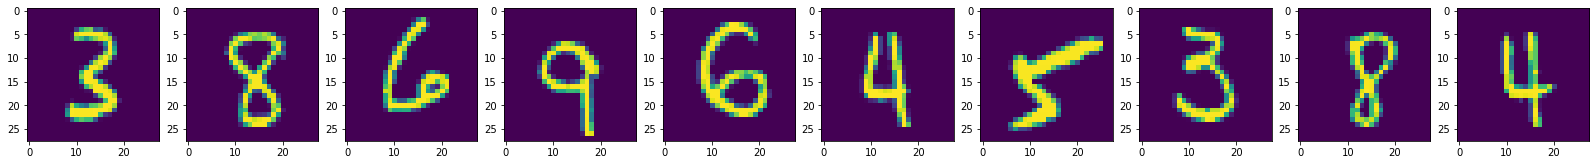

In [0]:
XX_val = np.reshape(X_val,[10000,784])
print(XX_val.shape)

print(y_val.shape)
print(y_val[0:10])
plt.figure(figsize=(28,28))
for i in range(10):    # from 0 to 9
  plt.subplot(1,10,i+1)
  plt.imshow(X_val[i, 0])
print(len(y_val))

yy_val = np.zeros(shape=(10000,10))
for i in range(10000):
  yy_val[i,y_val[i]]=1

for i in range(10):
  print(i+1,":",y_val[i],":", yy_val[i])
print(yy_val.shape)

(10000, 784)
(10000,)
[7 2 1 0 4 1 4 9 5 9]
10000
1 : 7 : [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 : 2 : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
3 : 1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4 : 0 : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 : 4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
6 : 1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
7 : 4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
8 : 9 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9 : 5 : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
10 : 9 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(10000, 10)


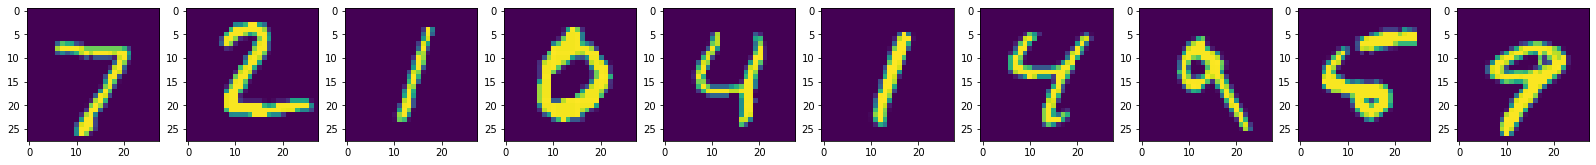

In [0]:
XX_test = np.reshape(X_test,[10000,784])
print(XX_test.shape)

print(y_test.shape)
print(y_test[0:10])
plt.figure(figsize=(28,28))
for i in range(10):    # from 0 to 9
  plt.subplot(1,10,i+1)
  plt.imshow(X_test[i, 0])
print(len(y_test))

yy_test = np.zeros(shape=(10000,10))
for i in range(10000):
  yy_test[i,y_test[i]]=1

for i in range(10):
  print(i+1,":",y_test[i],":", yy_test[i])
print(yy_test.shape)

In [249]:
# Calculate accuracy for MNIST test images
print("Validation Accuracy:")
#sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
sval = sess.run(accuracy, feed_dict={X: XX_val, Y: yy_val})
print(sval)
    
print("Testing Accuracy:")
#sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
stest = sess.run(accuracy, feed_dict={X: XX_test, Y: yy_test})
print(stest)


Validation Accuracy:
0.8669
Testing Accuracy:
0.854


In [0]:
<you could just as well create a computation graph here - loss, optimizers, all that stuff>

In [0]:
<this may or may not be a good place to run optimizer in a loop>

In [0]:
<this may be a perfect cell to write a training & evaluation loop in>

In [0]:
<predict & evaluate on test here, right? No cheating pls.>

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from previous assignment to classify some number against others (e.g. zero vs nonzero)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as T.nnet.softmax (stable)
  - probably better to use STOCHASTIC gradient descent (minibatch)
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - Do not initialize layers with zeros (due to symmetry effects). A gaussian noize with small sigma will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.